# Q4 Permutation Tests

In [73]:
import shap
from sklearn.model_selection import train_test_split
X,y = shap.datasets.adult() # Numerical version of data
X_display, y_display = shap.datasets.adult(display=True) # Human-readable data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train.dtypes

Age               float32
Workclass            int8
Education-Num     float32
Marital Status       int8
Occupation           int8
Relationship        int64
Race                 int8
Sex                  int8
Capital Gain      float32
Capital Loss      float32
Hours per week    float32
Country              int8
dtype: object

In [74]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, random_state=10)
clf.fit(X_train.values, y_train)

GradientBoostingClassifier(random_state=10)

(a) Report the zero-one classification error (using a classification threshold of 0.5) and log-loss for both the train and test sets.

In [75]:
from sklearn.metrics import log_loss

# Predict probabilities for train and test sets
train_pred = clf.predict_proba(X_train.values)[:, 1]
test_pred = clf.predict_proba(X_test.values)[:, 1]

# Convert probabilities to binary predictions using a threshold of 0.5
train_pred_binary = (train_pred >= 0.5).astype(int)
test_pred_binary = (test_pred >= 0.5).astype(int)

# Calculate zero-one classification error
train_error = (train_pred_binary != y_train).mean()
test_error = (test_pred_binary != y_test).mean()

# Calculate log-loss
train_loss = log_loss(y_train, train_pred)
test_loss = log_loss(y_test, test_pred)

train_error, train_loss, test_error, test_loss

(0.1314880221130221,
 0.2877588985367273,
 0.13373253493013973,
 0.2940315282808109)

(b) Implement the permutation test approach for the trained model. For each feature, measure the change in the test set zero-one error after permuting the corresponding feature column. Visualize the importance values with a bar plot.

In [76]:
import numpy as np

def perm_test(clf, X_test, y_test):
    # Calculate the original zero-one error
    original_error = test_error

    # Initialize an array to store the error changes
    error_changes = np.zeros(X_test.shape[1])

    # Permute each feature column and calculate the error change
    for i in range(X_test.shape[1]):
        X_permuted = X_test.copy()
        np.random.shuffle(X_permuted[:, i])
        y_pred_permuted = clf.predict(X_permuted)
        error_changes[i] = ((y_pred_permuted >= 0.5).astype(int) != y_test).mean() - original_error

    return error_changes

# Perform permutation test
error_changes = perm_test(clf, X_test.values, y_test)

# Print the error changes for each feature
# for feature, error_change in zip(X_test.columns, error_changes):
#     print(f'{feature}: {error_change}')



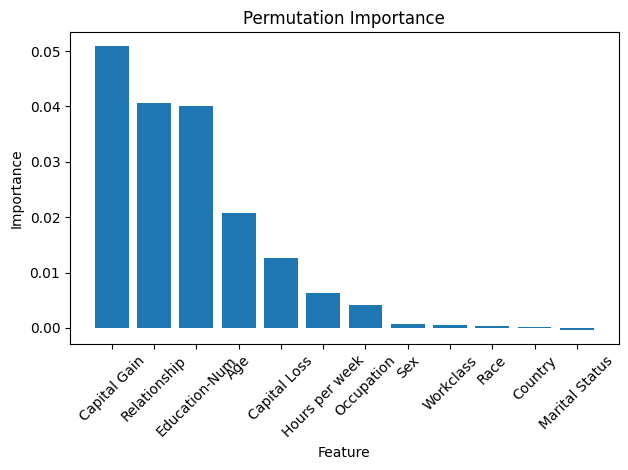

In [77]:
import matplotlib.pyplot as plt

# Get feature names
feature_names = X_test.columns

# Sort feature importances in descending order
sorted_indices = error_changes.argsort()[::-1]
sorted_importances = error_changes[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Visualize importance values with a bar plot
# plt.figure(figsize=(7, 7))
plt.bar(sorted_feature_names, sorted_importances)
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Permutation Importance')
plt.tight_layout()
plt.savefig('q4_b.png')

(c) Permutation tests are inherently stochastic because they permute features randomly. Run the permutation test from part (b) 10 times and visualize the variance in the importance values using a bar plot with standard deviation error bars.

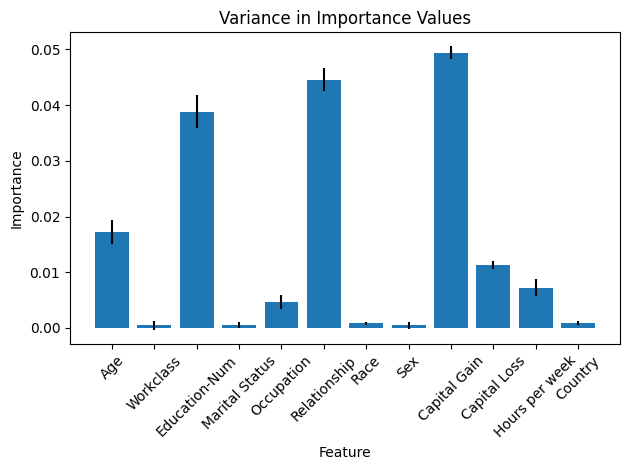

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Run permutation test 10 times and collect importance values
importance_values = []
for _ in range(10):
    error_changes = perm_test(clf, X_test.values, y_test)
    importance_values.append(error_changes)

# Calculate mean and standard deviation of importance values
mean_importance = np.mean(importance_values, axis=0)
std_importance = np.std(importance_values, axis=0)

# Plot the importance values with error bars
plt.bar(feature_names, mean_importance, yerr=std_importance)
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Variance in Importance Values')
plt.tight_layout()
plt.savefig('q4_c.png')

(d) One possible variation of the permutation test is to change the feature removal approach. Implement a new method similar to (b) that removes features by setting them to their mean instead of permuting them. Visualize the importance values using a bar plot.

Age: 0.007369875633348677
Workclass: -0.0001535390756947641
Education-Num: 0.017964071856287428
Marital Status: 0.0006141563027790564
Occupation: 0.00936588361738061
Relationship: 0.048978965146629805
Race: 0.0006141563027790564
Sex: 0.0
Capital Gain: 0.030861354214647613
Capital Loss: 0.007369875633348677
Hours per week: 0.003070781513895282
Country: 0.0007676953784738205


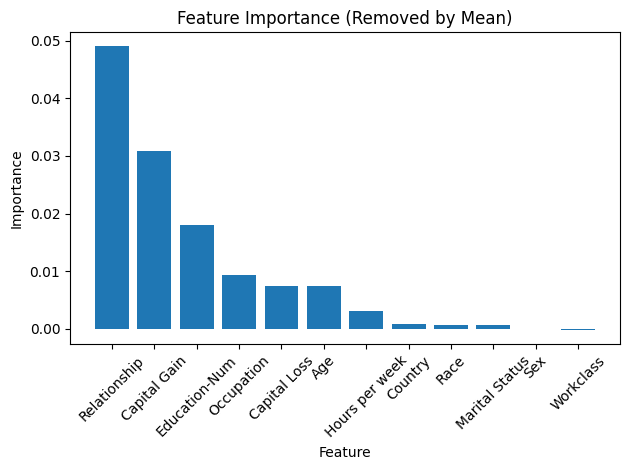

In [7]:
def remove_by_mean(clf, X, y):
    # Fit the model on the original data
    original_error = test_error
    
    # Initialize an array to store the error changes
    error_changes = np.zeros(X.shape[1])
    
    # Perform feature removal by setting features to their mean
    for i in range(X.shape[1]):
        # Create a copy of the feature matrix
        X_removed = X.copy()
        X_removed[:, i] = np.mean(X_removed[:, i])
    
        # Fit the model on the permuted data
        y_pred_removed = clf.predict(X_removed)
        
        error_changes[i] = ((y_pred_removed >= 0.5).astype(int) != y).mean() - original_error
    
    return error_changes

# Perform permutation test
error_changes_removed = remove_by_mean(clf, X_test.values, y_test)

# Print the error changes for each feature
for feature, error_change in zip(X_test.columns, error_changes_removed):
    print(f'{feature}: {error_change}')
    
# Get feature names
feature_names = X_test.columns

# Sort feature importances in descending order
sorted_indices = error_changes_removed.argsort()[::-1]
sorted_importances = error_changes_removed[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Visualize importance values with a bar plot
plt.bar(sorted_feature_names, sorted_importances)
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance (Removed by Mean)')
plt.tight_layout()
plt.savefig('q4_d.png')


(e) Another possible variation is to change the model behavior we measure. Implement a new method similar to (b) that measures the change in the test set log-loss rather than the zero-one error. Visualize the importance values using a bar plot.

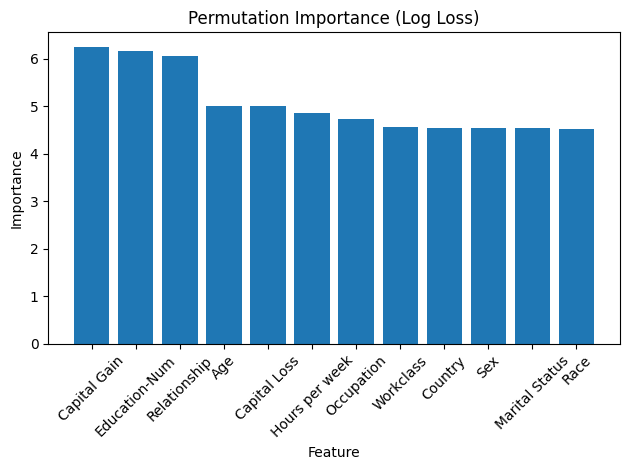

In [8]:
def perm_test_log_loss(clf, X_test, y_test):
    original_error = test_loss # test_loss = log_loss(y_test, test_pred)

    # Initialize an array to store the error changes
    error_changes = np.zeros(X_test.shape[1])

    # Permute each feature column and calculate the error change
    for i in range(X_test.shape[1]):
        X_permuted = X_test.copy()
        np.random.shuffle(X_permuted[:, i])
        y_pred_permuted = clf.predict(X_permuted)
        error_changes[i] = log_loss(y_test, y_pred_permuted) - original_error

    return error_changes

# Perform permutation test
error_changes = perm_test_log_loss(clf, X_test.values, y_test)

# Get feature names
feature_names = X_test.columns

# Sort feature importances in descending order
sorted_indices = error_changes.argsort()[::-1]
sorted_importances = error_changes[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Visualize importance values with a bar plot
plt.bar(sorted_feature_names, sorted_importances)
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Permutation Importance (Log Loss)')
plt.tight_layout()
plt.savefig('q4_e.png')


# Q5 Popular Feature Importance Packages

(a) 
Note that both TreeSHAP and KernelSHAP require a set of baselines, which are used to replace held-out features with samples from their marginal distribution. For this problem, use the last 100 samples from the test set (X_test[-100:]) as the baselines.
Visualize the results for each method using three separate summary plots

In [4]:
import numpy as np

explicands = X_test[:200]
baselines = X_test[-100:]

### TreeSHAP

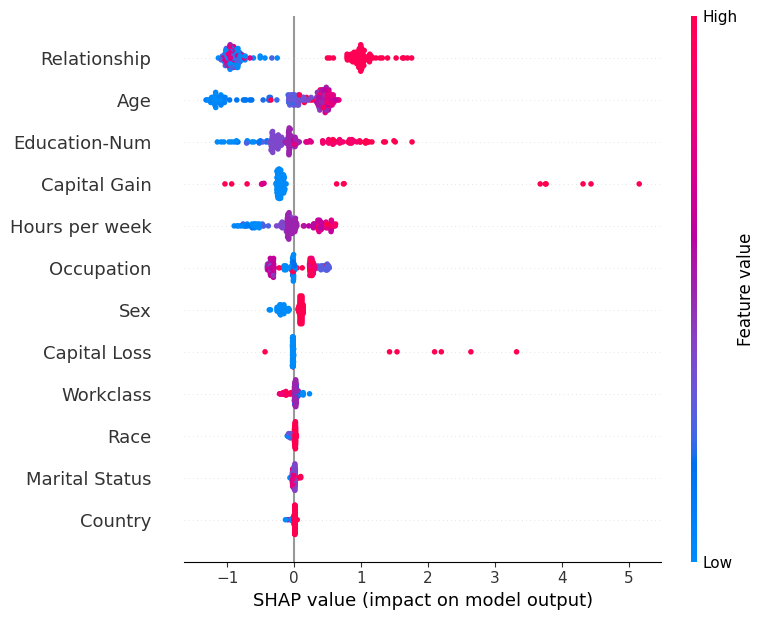

In [5]:
import shap
explainer_tree = shap.TreeExplainer(clf, baselines)
attributions_tree = explainer_tree.shap_values(explicands)
shap.summary_plot(attributions_tree, explicands)

In [85]:
attributions_tree.shape, explicands.shape

((200, 12), (200, 12))

In [119]:
type(attributions_tree)

numpy.ndarray

According to the summary plots, the most important feature for TreeSHAP is Capital Gain.

### KernelSHAP

In [6]:
explainer_kernel = shap.KernelExplainer(clf.predict_proba, baselines)
attributions_kernel = explainer_kernel.shap_values(explicands)[:,:,1]

100%|██████████| 200/200 [01:23<00:00,  2.38it/s]


In [112]:
attributions_kernel[0]

array([ 0.01738053,  0.0032441 , -0.01079766,  0.00054756,  0.03372724,
       -0.15629574,  0.00089272, -0.0204124 , -0.03363222, -0.00334873,
       -0.01159401,  0.00085227])

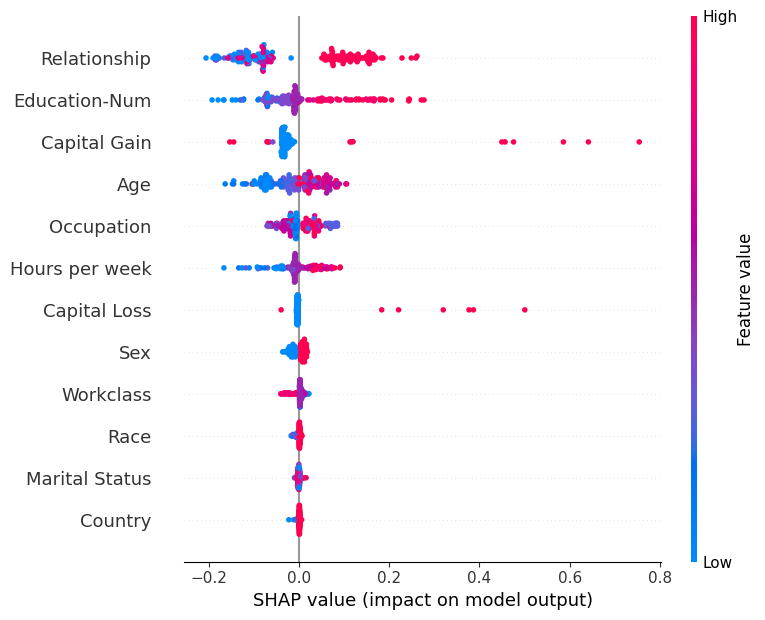

In [91]:
shap.summary_plot(attributions_kernel, explicands)

According to the summary plots, the most important feature for KernelSHAP is Capital Gain.

LIME

In [123]:
import shap
import pandas as pd
import lime.lime_tabular
import matplotlib.pyplot as plt

explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train.values)

attributions_lime = []
for explicand in explicands.values:
    # exp = explainer_lime.explain_instance(explicand, clf.predict_proba)
    # exp.as_pyplot_figure()
    attribution = explainer_lime.explain_instance(explicand, clf.predict_proba, num_features=12).local_exp[1]
    # attribution: [ (feature_index, feature_attribution), (...), ... ]

    df_attribution = pd.DataFrame(attribution, columns=['feature_index', 'feature_attribution'])
    df_attribution = df_attribution.set_index('feature_index').sort_index()
    
    # Note: you must reshape the attribution and run explain_instance for every explicand
    attributions_lime.append(np.array(df_attribution).squeeze())  

# Convert list of attributions to numpy array
attributions_lime = np.array(attributions_lime)



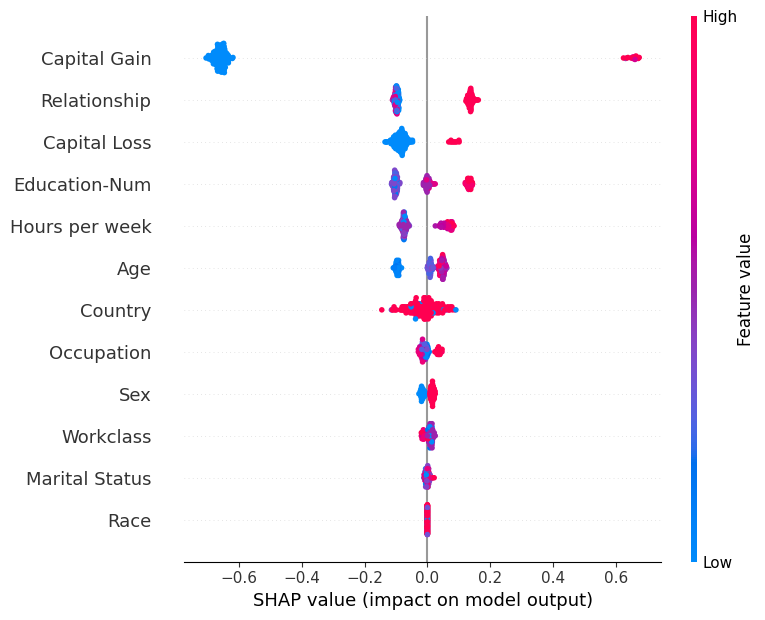

In [126]:
shap.summary_plot(attributions_lime, explicands.values, feature_names=explicands.columns)

In [125]:
X_train.columns[8]

'Capital Gain'

According to the summary plots, the most important feature for LIME is Capital Gain.

In [124]:
# import shap
# import lime.lime_tabular

# explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['0', '1'], categorical_features=[1,3,4,5,6,7,11])
# attribution = explainer_lime.explain_instance(explicands.values[0], clf.predict_proba, num_features=12).local_exp[1]
# # Note: you must reshape the attribution and run explain_instance for every explicand

# shap.summary_plot(np.array(attribution), explicands.values[0])


(b) Visualize the attributions from each method for the features “Age” and “Hours per week” with a scatter plot, putting the feature value on the x-axis and the feature attribution on the y-axis. Use the matplotlib library to generate the plots. Based on these plots, what observations can you make about how the these features relate to the model’s income prediction?

In [16]:
import matplotlib.pyplot as plt

explicands_age = explicands['Age']
explicands_hours_per_week = explicands['Hours per week']

### TreeSHAP

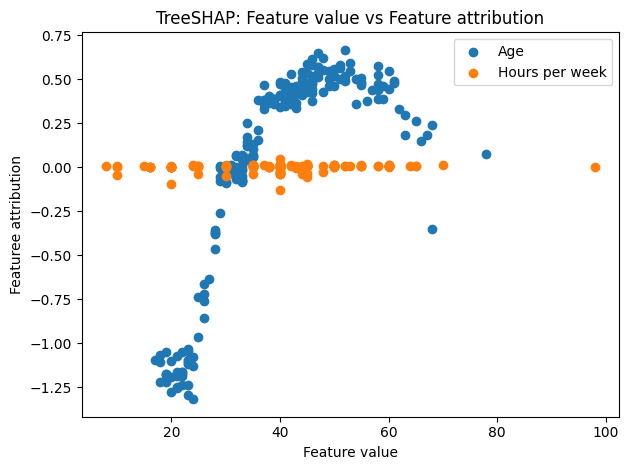

In [23]:
age_tree = attributions_tree[:, 0]
hours_per_week_tree = attributions_tree[:, 11]

plt.scatter(explicands_age, age_tree)
plt.scatter(explicands_hours_per_week, hours_per_week_tree)
plt.legend(['Age', 'Hours per week'])
plt.xlabel('Feature value')
plt.ylabel('Featuree attribution')
plt.title('TreeSHAP: Feature value vs Feature attribution')
plt.tight_layout()
plt.savefig('q5_b1.png')




### KernelSHAP

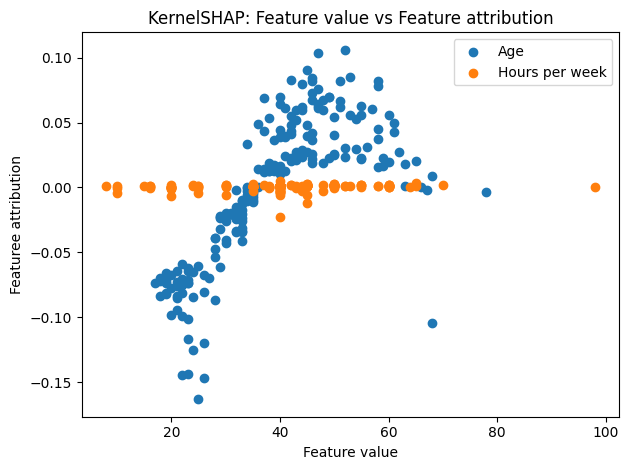

In [24]:
age_kernel = attributions_kernel[:, 0]
hours_per_week_kernel = attributions_kernel[:, 11]

plt.scatter(explicands_age, age_kernel)
plt.scatter(explicands_hours_per_week, hours_per_week_kernel)
plt.legend(['Age', 'Hours per week'])
plt.xlabel('Feature value')
plt.ylabel('Featuree attribution')
plt.title('KernelSHAP: Feature value vs Feature attribution')
plt.tight_layout()
plt.savefig('q5_b2.png')

### LIME

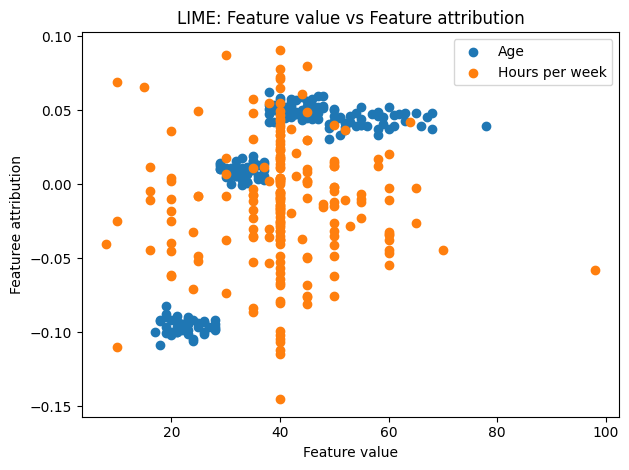

In [127]:
age_kernel = attributions_lime[:, 0]
hours_per_week_kernel = attributions_lime[:, 11]

plt.scatter(explicands_age, age_kernel)
plt.scatter(explicands_hours_per_week, hours_per_week_kernel)
plt.legend(['Age', 'Hours per week'])
plt.xlabel('Feature value')
plt.ylabel('Featuree attribution')
plt.title('LIME: Feature value vs Feature attribution')
plt.tight_layout()
plt.savefig('q5_b3.png')

From these plots, we can tell that *Age* generally has a higher and more positive impact as its value goes larger; while *Hours per week* does not have apparent pattern in *LIME*, but from *TreeSHAP* and *KernelSHAP*, it does not have much contribution on income prediction.

(c) Visualize the attributions from each method for the sample with index 1 in the test set (X_test.iloc[1]) using a bar plot, with the feature names on the y-axis and the feature attributions on the x-axis . Based on the TreeSHAP attributions, describe one feature that makes a strong positive contribution to this sample’s prediction and one feature that makes a strong negative contribution.

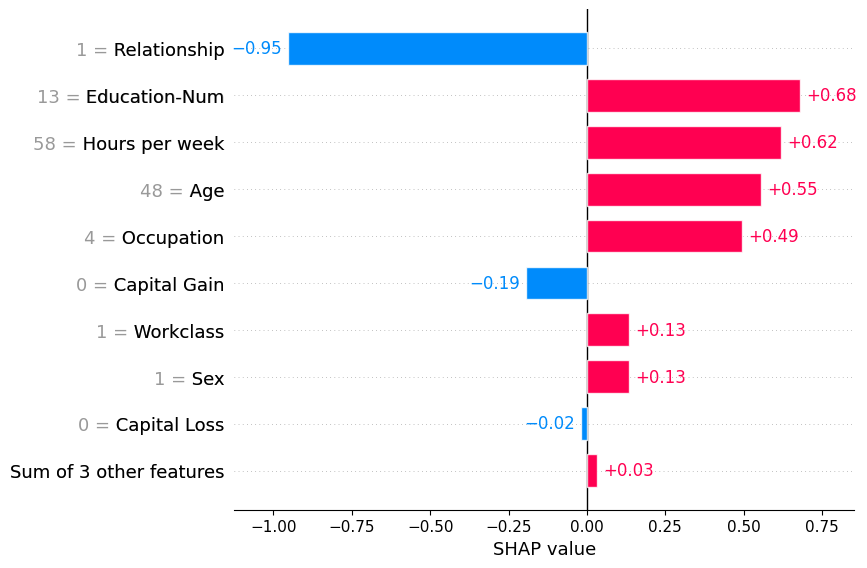

<Figure size 640x480 with 0 Axes>

In [55]:
sample = X_test.iloc[1]

# TreeSHAP
shap.plots.bar(explainer_tree(sample))

From TreeSHAP, we can tell that *Education-Num* makes the strongest positive contribution and *Relationship* makes the strongest negative contribution.

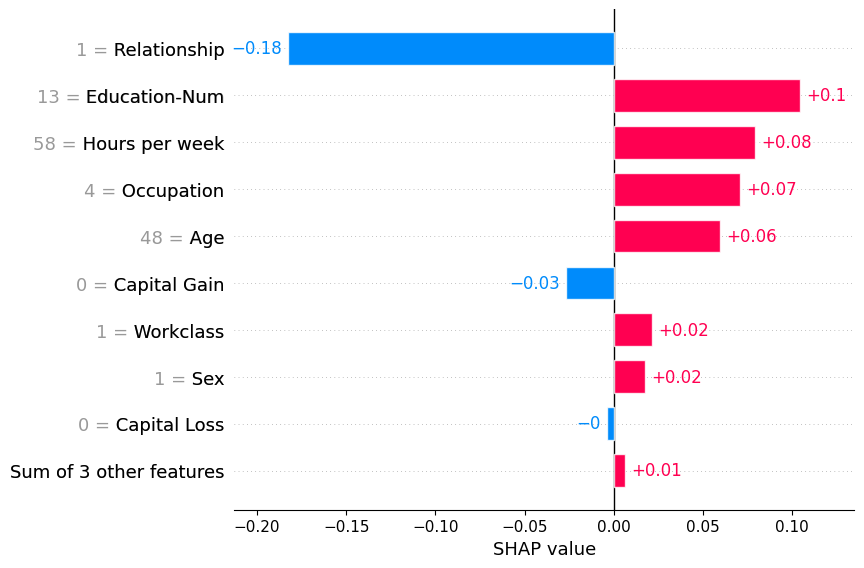

In [49]:
# KernelSHAP
shap.plots.bar(explainer_kernel(sample)[:,1])

/Users/zhao/opt/anaconda3/envs/xai/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/zhao/opt/anaconda3/envs/xai/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/zhao/opt/anaconda3/envs/xai/lib/python3.12/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consi

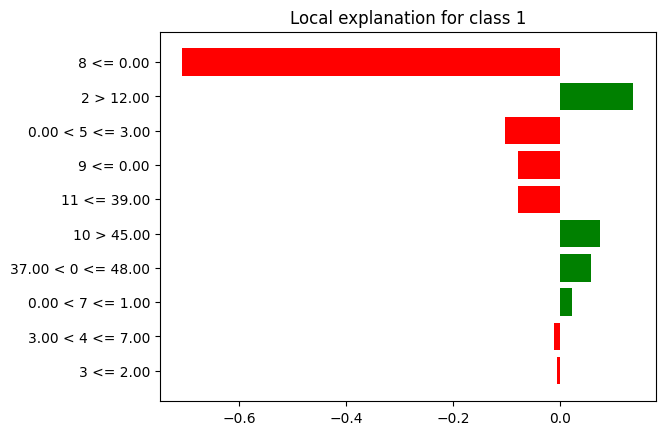

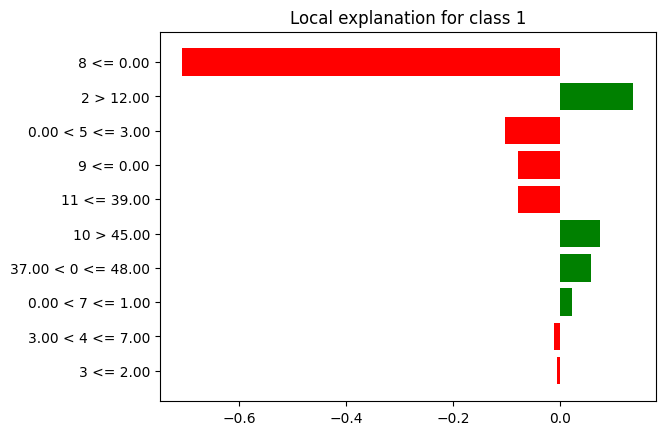

In [54]:
# LIME
explainer_lime.explain_instance(sample, clf.predict_proba).as_pyplot_figure()

(d) An important parameter for KernelSHAP is the number of samples (the nsamples argument in KernelExplainer’s shap_values() function). Using more samples will improve the quality of the final feature attribution estimates, but it is more costly.2 For the previous parts of this problem, we used the default setting of this parameter (see here).

To investigate this parameter, run KernelSHAP for the sample with index 1 in the test set (X_test.iloc[1]) with nsamples=10, nsamples=100 and nsamples=1000 for 10 runs each. Once again, use a bar plot to depict the mean local feature attributions, but this time include error bars to depict standard deviation across runs of the local feature attributions for each number of samples. Explain the result.

In [64]:
sample = X_test.iloc[1]
n_samples_grid = [10,100,1000]
it = 10
shap_values_results = []

# KernelSHAP
for n_samples in n_samples_grid:
    shap_values_list = []
    for i in range(it):
        result = explainer_kernel.shap_values(sample, nsamples=n_samples)[:,1]
        shap_values_list.append(result)
    shap_values_results.append(np.array(shap_values_list))
    
shap_values_results = np.array(shap_values_results)

/Users/zhao/opt/anaconda3/envs/xai/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.406e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/zhao/opt/anaconda3/envs/xai/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.266e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/zhao/opt/anaconda3/envs/xai/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.133e-03, with an act

In [65]:
shap_values_results.shape

(3, 10, 12)

In [70]:
std_importance.shape, mean_importance.shape

((3, 12), (3, 12))

/var/folders/4b/glzhdmt50kq7c2tgzkkh08hm0000gn/T/ipykernel_39992/1135968763.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(feature_names, rotation=45, fontsize=7)
/var/folders/4b/glzhdmt50kq7c2tgzkkh08hm0000gn/T/ipykernel_39992/1135968763.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(feature_names, rotation=45, fontsize=7)
/var/folders/4b/glzhdmt50kq7c2tgzkkh08hm0000gn/T/ipykernel_39992/1135968763.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(feature_names, rotation=45, fontsize=7)


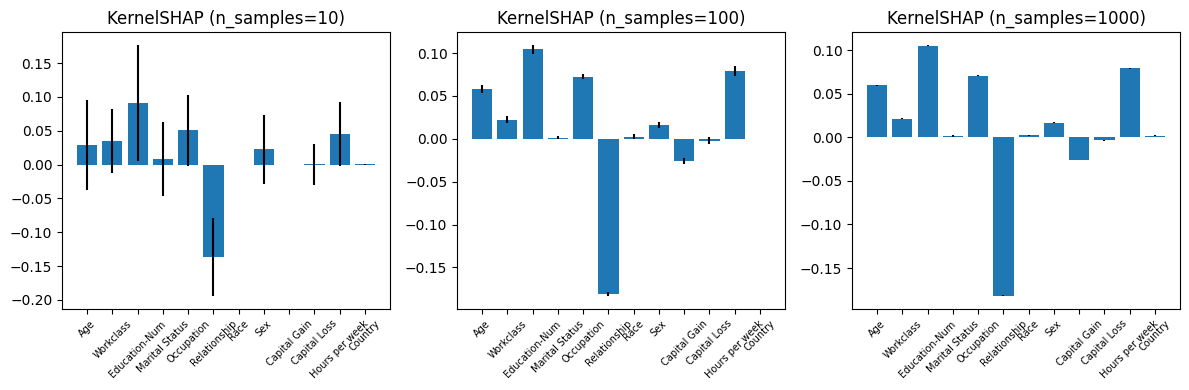

In [85]:
# Calculate mean and standard deviation of importance values
mean_importance = np.mean(shap_values_results, axis=1)
std_importance = np.std(shap_values_results, axis=1)

# Plot the importance values with error bars
feature_names = X_test.columns

# plt.bar(feature_names, mean_importance[0], yerr=std_importance[0])

# Create the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    axes[i].bar(feature_names, mean_importance[i], yerr=std_importance[i])
    axes[i].set_title(f'KernelSHAP (n_samples={n_samples_grid[i]})')
    axes[i].set_xticklabels(feature_names, rotation=45, fontsize=7)

# Adjust the spacing between subplots
plt.tight_layout()
plt.savefig('q5_d.png')

From these plot, we can tell that as *n_samples* goes large, variances of feature attributions get smaller and the mean value distributes more centerialized to the true SHAP value.